# Univariate Time Series Forecasting

In [198]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Conv1D, Flatten, GRU
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Load & Visualise Data

In [2]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df.index = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")
df.drop(["Date Time"], axis=1, inplace=True)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
# Data is every 10 minutes, there is also a lot probably too much
df = df[5::6] # Starting from the 5th point, take a point row every 6th
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


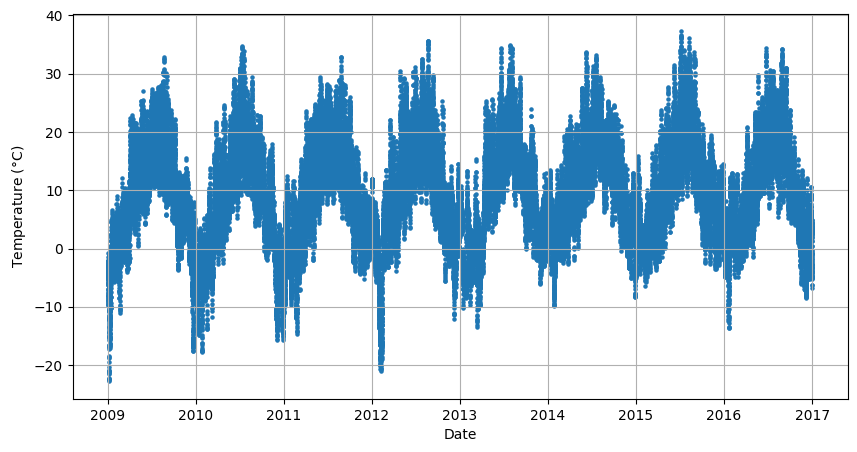

In [4]:
plt.figure(figsize=(10,5))
plt.scatter(df.index, df["T (degC)"], s=5)
plt.xlabel("Date")
plt.ylabel(r"Temperature ($\degree$C)")
plt.grid()
plt.show()

# TODO
1. Analyse trend and seasonality
2. De-trend?

In [5]:
# Port the dataframe to a "machine learning ready" format
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        y.append(df_as_np[i+5])
    return np.array(X), np.array(y)

In [6]:
WINDOW_SIZE = 5
X, y = df_to_X_y(df["T (degC)"], WINDOW_SIZE) # Temperatures 1,2,3,4,5 predict temperature 6 etc.
X.shape, y.shape

((70086, 5, 1), (70086,))

## Building A Model

In [7]:
# First split data into appropriate sets, note the shuffle=False. This is a time series so we must not shuffle our data
lx = len(X)
X_train, y_train = X[:int(np.floor(lx * 0.7))], y[:int(np.floor(lx * 0.7))]
X_val, y_val = X[int(np.floor(lx * 0.7)):int(np.floor(lx * 0.85))], y[int(np.floor(lx * 0.7)):int(np.floor(lx * 0.85))]
X_test, y_test = X[int(np.floor(lx * 0.85)):], y[int(np.floor(lx * 0.85)):]

In [70]:
model = Sequential()
model.add(InputLayer((5, 1)))
model.add(LSTM(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear')) # Trying to predict a continuous value

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
cp = ModelCheckpoint('models/jena_climate_model.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-4), metrics=[RootMeanSquaredError()])

In [72]:
# Now we train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=8, callbacks=[cp])

Epoch 1/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 81.1102 - root_mean_squared_error: 8.8004 - val_loss: 5.2246 - val_root_mean_squared_error: 2.2857
Epoch 2/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 3.5855 - root_mean_squared_error: 1.8876 - val_loss: 1.6404 - val_root_mean_squared_error: 1.2808
Epoch 3/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 1.3020 - root_mean_squared_error: 1.1392 - val_loss: 1.0116 - val_root_mean_squared_error: 1.0058
Epoch 4/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.8353 - root_mean_squared_error: 0.9138 - val_loss: 0.8165 - val_root_mean_squared_error: 0.9036
Epoch 5/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.7158 - root_mean_squared_error: 0.8460 - val_loss: 0.7458 - val_root_mean_squared_error: 0.8636
Epoch 6/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.6861 - root_mean_squared_error: 0.8283 - val_loss: 0.7202 - val_root_mean_squared_error: 0.8486
Epoch 7/8
1534/1534 ━━━━━━━━━━━━━━━━━━━

## Evaluating Training

In [73]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame({'Train Predictions': train_predictions, 'Train Actuals': y_train})

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


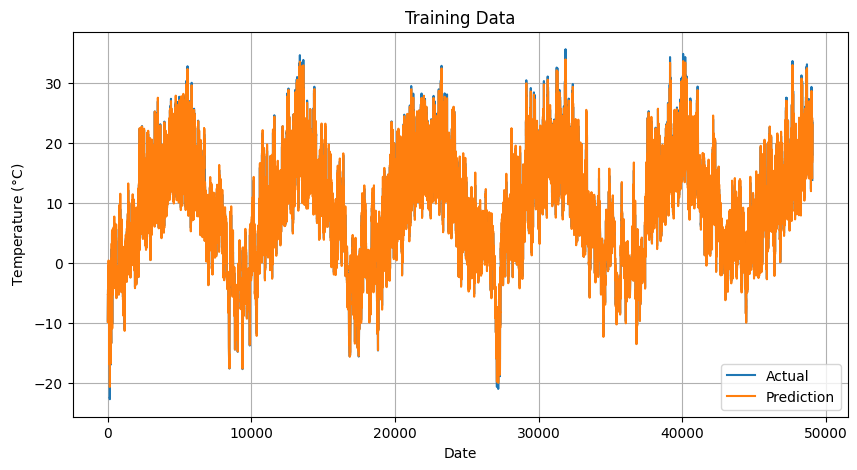

In [74]:
plt.figure(figsize=(10,5))
plt.plot(train_results["Train Actuals"], label="Actual")
plt.plot(train_results["Train Predictions"], label="Prediction")
plt.title("Training Data")
plt.legend()
plt.xlabel("Date")
plt.ylabel(r"Temperature ($\degree$C)")
plt.grid()
plt.show()

In [75]:
val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame({'Val Predictions': val_predictions, 'Val Actuals': y_val})

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


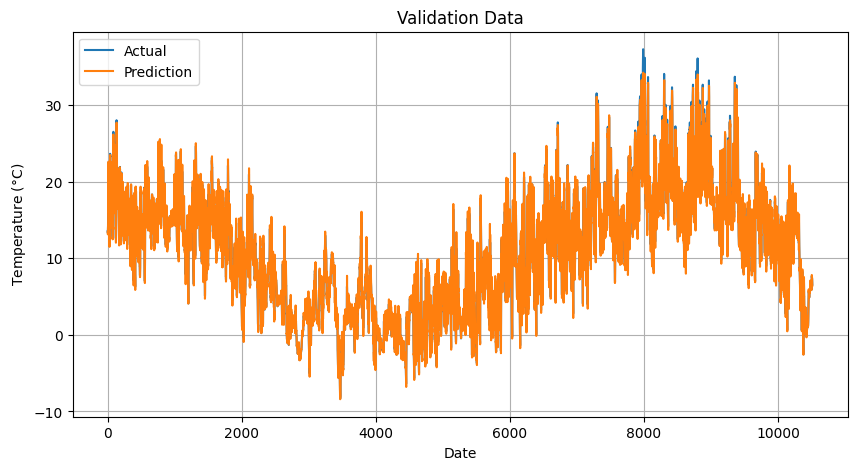

In [76]:
plt.figure(figsize=(10,5))
plt.plot(val_results["Val Actuals"], label="Actual")
plt.plot(val_results["Val Predictions"], label="Prediction")
plt.title("Validation Data")
plt.legend()
plt.xlabel("Date")
plt.ylabel(r"Temperature ($\degree$C)")
plt.grid()
plt.show()

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


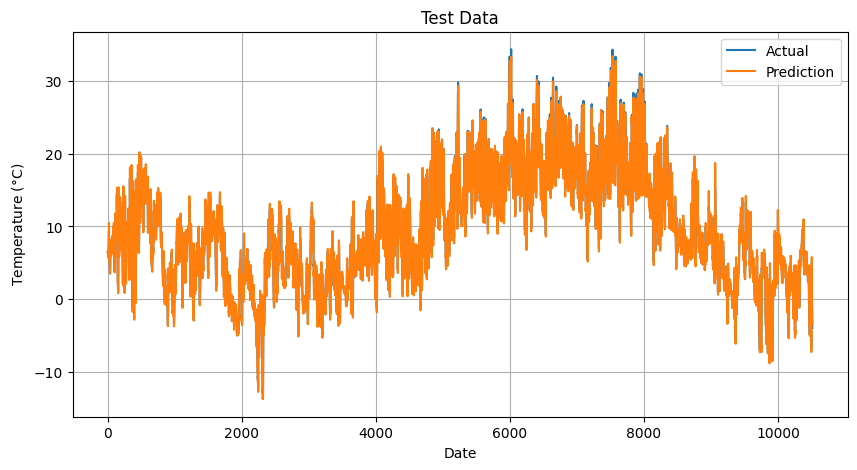

In [77]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame({'Test Predictions': test_predictions, 'Test Actuals': y_test})

plt.figure(figsize=(10,5))
plt.plot(test_results["Test Actuals"], label="Actual")
plt.plot(test_results["Test Predictions"], label="Prediction")
plt.title("Test Data")
plt.legend()
plt.xlabel("Date")
plt.ylabel(r"Temperature ($\degree$C)")
plt.grid()
plt.show()

In [83]:
np.sqrt(mse(y_test, test_predictions)) # Typically off by about 0.75 C not bad!

0.7597768152120427

In [85]:
mae(y_test, test_predictions)

0.5196057721093391

# Multivariate Forecasting
We can probably improve our predictions (significantly) but using other data that are correlated to the temperature.

In [8]:
def plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame({'predictions': predictions, 'actuals': y})
    plt.plot(df['predictions'][start:end], label="Predictions")
    plt.plot(df['actuals'][start:end], label="Actual")
    plt.legend()
    plt.show()
    #return df, mse(y, predictions)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


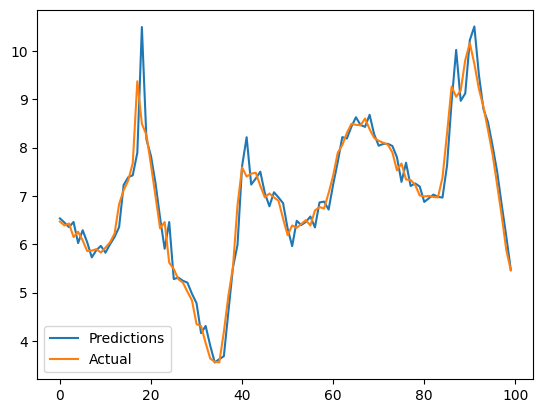

In [96]:
plot_predictions(model, X_test, y_test)

## Using a CNN For Forecasting

In [100]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='linear'))
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 4, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257 (8.82 KB)

 Trainable params: 2,257 (8.82 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
cp2 = ModelCheckpoint('models/jena_climate_model_cnn.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-4), metrics=[RootMeanSquaredError()])
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=8, callbacks=[cp])

Epoch 1/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 19.0186 - root_mean_squared_error: 4.0075 - val_loss: 1.6239 - val_root_mean_squared_error: 1.2743
Epoch 2/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1.4101 - root_mean_squared_error: 1.1866 - val_loss: 0.9811 - val_root_mean_squared_error: 0.9905
Epoch 3/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.9384 - root_mean_squared_error: 0.9684 - val_loss: 0.7638 - val_root_mean_squared_error: 0.8740
Epoch 4/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7648 - root_mean_squared_error: 0.8745 - val_loss: 0.6992 - val_root_mean_squared_error: 0.8362
Epoch 5/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7120 - root_mean_squared_error: 0.8436 - val_loss: 0.7016 - val_root_mean_squared_error: 0.8376
Epoch 6/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.6850 - root_mean_squared_error: 0.8276 - val_loss: 0.6797 - val_root_mean_squared_error: 0.8244
Epoch 7/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9

We see almost the same loss and error as the LSTM but with an enormous reduction in number of parameters, this is benefical not just for training but during deployment.

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


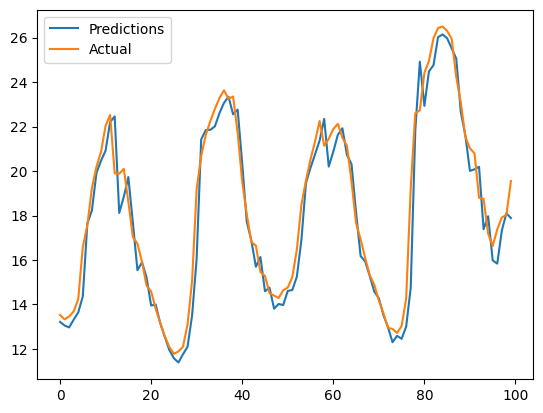

In [102]:
plot_predictions(model2, X_val, y_val)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


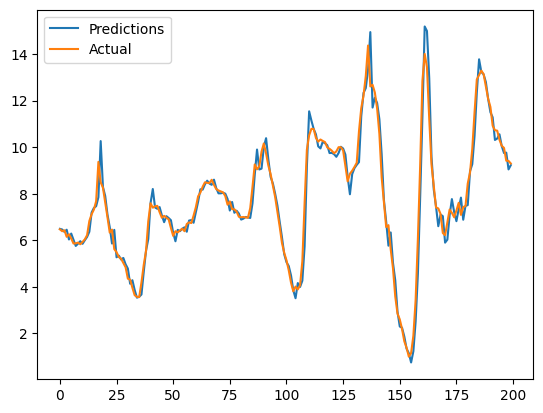

In [104]:
plot_predictions(model2, X_test, y_test, start=0, end=200)

## Balance Between CNN and LSTM - The GRU

In [10]:
model3 = Sequential()
model3.add(InputLayer((5,1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

2024-06-17 10:08:09.243638: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-17 10:08:09.243696: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-17 10:08:09.243711: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-17 10:08:09.244124: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-17 10:08:09.244526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,393 (52.32 KB)

 Trainable params: 13,393 (52.32 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
cp3 = ModelCheckpoint('models/jena_climate_model_gru.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-4), metrics=[RootMeanSquaredError()])
model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=8, callbacks=[cp3])

Epoch 1/8


2024-06-17 10:09:02.006910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 92.1985 - root_mean_squared_error: 9.3675 - val_loss: 5.0734 - val_root_mean_squared_error: 2.2524
Epoch 2/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 2.9772 - root_mean_squared_error: 1.7191 - val_loss: 1.5899 - val_root_mean_squared_error: 1.2609
Epoch 3/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 1.1485 - root_mean_squared_error: 1.0712 - val_loss: 1.0021 - val_root_mean_squared_error: 1.0010
Epoch 4/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.8277 - root_mean_squared_error: 0.9093 - val_loss: 0.7933 - val_root_mean_squared_error: 0.8907
Epoch 5/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.7078 - root_mean_squared_error: 0.8412 - val_loss: 0.7181 - val_root_mean_squared_error: 0.8474
Epoch 6/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.6629 - root_mean_squared_error: 0.8142 - val_loss: 0.6897 - val_root_mean_squared_error: 0.8305
Epoch 7/8
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


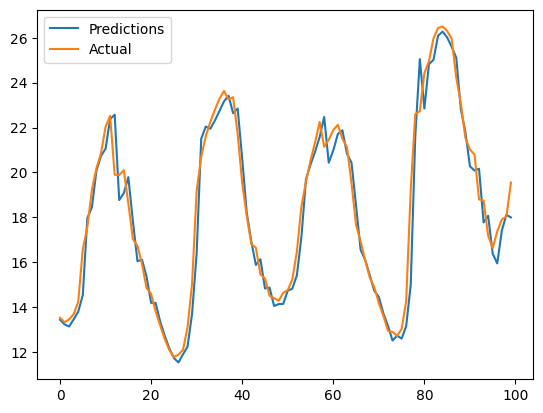

In [13]:
plot_predictions(model3, X_val, y_val)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


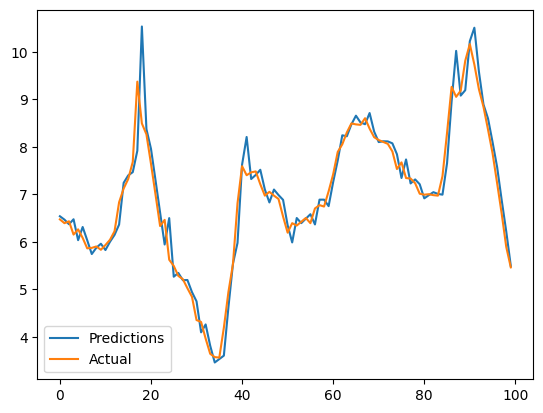

In [14]:
plot_predictions(model3, X_test, y_test)

In [15]:
test_predictions = model3.predict(X_test)
np.sqrt(mse(y_test, test_predictions))

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step


0.7503588305843856

In [16]:
mae(y_test, test_predictions)

0.5145019380597319

# Multivariate Forecasting

In [19]:
temp_df = pd.DataFrame({'Temperature': df['T (degC)']})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09
...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09
2016-12-31 20:10:00,-1.40,1.483215e+09
2016-12-31 21:10:00,-2.75,1.483219e+09


In [20]:
day = 60 * 60 * 24 # Number of seconds in a day
year = 365.2425 * day # Number of seconds in a year

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,1.230775e+09,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,1.230779e+09,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,1.230782e+09,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,1.230786e+09,0.965926,0.258819,0.012916,0.999917


In [21]:
temp_df.drop('Seconds', axis=1, inplace=True)

## Building the training data [Important]

In [23]:
# Port the dataframe to a "machine learning ready" format
# [[[t1], [t2], [t3], [t4], [t5]]] -- predict --> [t6] (univariate)
# [[[t1, f1], [t2, f2], [t3, f3], [t4, f4], [t5, f5]]] -- predict --> [t6] (multivariate)

def df_to_X_y_multivariate(df, window_size=6): # Changed window size as using 5 variables just so we can see shape diff.
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i+window_size]] # Rows of data
        X.append(row)
        y.append(df_as_np[i+window_size][0]) # COuld forecast multi-variables here but we don't
    return np.array(X), np.array(y)

In [42]:
X2, y2 = df_to_X_y_multivariate(temp_df, window_size=6) # last 6 timesteps used to predict the 7th timestep
X2.shape, y2.shape

((70085, 6, 5), (70085,))

In [43]:
X_train, y_train = X2[:60000], y2[:60000]
X_val, y_val = X2[60000:65000], y2[60000:65000]
X_test, y_test = X2[65000:], y2[65000:]
X_train.shape, y_train.shape

((60000, 6, 5), (60000,))

In [44]:
# We need to scale our data to be roughly [-1, 1] range
scaler = StandardScaler() # Normalised (mu=0, std=1)
scaler.fit(X_train[:, :, 0])

def preprocess(x, scaler):
    x[:, :, 0] = scaler.transform(x[:, :, 0])
    return x

In [45]:
X_train = preprocess(X_train, scaler)
X_val = preprocess(X_val, scaler)
X_test = preprocess(X_test, scaler)

## Building a Model

In [48]:
model4 = Sequential()
model4.add(InputLayer((6, 5))) # 6 timesteps and 5 input variables
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))
model4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
cp4 = ModelCheckpoint('models/jena_climate_model_lstm_multivariate.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-4), metrics=[RootMeanSquaredError()])
model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=8, callbacks=[cp4])

Epoch 1/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 77.7098 - root_mean_squared_error: 8.5404 - val_loss: 4.0174 - val_root_mean_squared_error: 2.0043
Epoch 2/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 5.5252 - root_mean_squared_error: 2.3447 - val_loss: 1.8959 - val_root_mean_squared_error: 1.3769
Epoch 3/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 2.0569 - root_mean_squared_error: 1.4319 - val_loss: 1.0274 - val_root_mean_squared_error: 1.0136
Epoch 4/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 1.1276 - root_mean_squared_error: 1.0616 - val_loss: 0.7342 - val_root_mean_squared_error: 0.8568
Epoch 5/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.8359 - root_mean_squared_error: 0.9142 - val_loss: 0.5749 - val_root_mean_squared_error: 0.7582
Epoch 6/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.6885 - root_mean_squared_error: 0.8296 - val_loss: 0.4961 - val_root_mean_squared_error: 0.7044
Epoch 7/8
1875/1875 ━━━━━━━━━━━━━━━━━━━

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


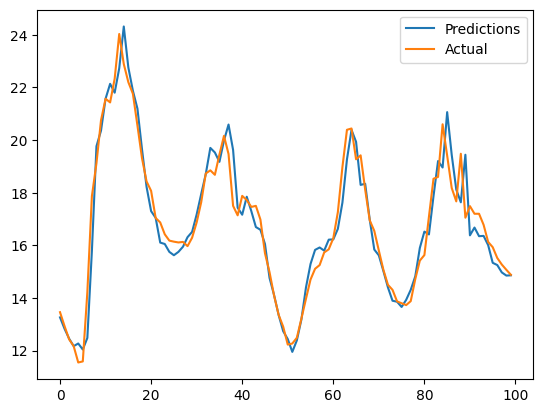

In [51]:
plot_predictions(model4, X_test, y_test)

In [53]:
mae(y_test, model4.predict(X_test))

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.4886667554893676

## Multivariate and Multi-Output

Now lets try adding the pressure...

In [86]:
temp_df['p'] = df['p (mbar)']
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos,p
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950,996.50
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942,996.62
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934,996.84
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926,996.99
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917,997.46


In [189]:
def df_to_X_y_multivariate(df, window_size=6): # Changed window size as using 5 variables just so we can see shape diff.
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i+window_size]] # Rows of data
        X.append(row)
        y.append([df_as_np[i+window_size][0], df_as_np[i+window_size][5]]) # Multiple predictions
    return np.array(X), np.array(y)

X2, y2 = df_to_X_y_multivariate(temp_df, window_size=7)
X2.shape, y2.shape

((70084, 7, 6), (70084, 2))

In [190]:
X_train, y_train = X2[:60000], y2[:60000]
X_val, y_val = X2[60000:65000], y2[60000:65000]
X_test, y_test = X2[65000:], y2[65000:]

In [191]:
# Note we also need to preprocess our OUTPUT! 
mu1 = np.mean(X_train[:, :, 0]) # Training temperature mean
mu2 = np.mean(X_train[:, :, 5]) # Training pressure mean
std1 = np.std(X_train[:, :, 0]) # Training temperature std
std2 = np.std(X_train[:, :, 5]) # Training pressure std

def preprocess_new(x):
    x[:, :, 0] = (x[:, :, 0] - mu1) / std1
    x[:, :, 5] = (x[:, :, 5] - mu2) / std2
    return x

def preprocess_output(y):
    y[:, 0] = (y[:, 0] - mu1) / std1
    y[:, 1] = (y[:, 1] - mu2) / std2
    return y

X_train = preprocess_new(X_train)
X_val = preprocess_new(X_val)
X_test = preprocess_new(X_test)

y_train = preprocess_output(y_train)
y_val = preprocess_output(y_val)
y_test = preprocess_output(y_test) # No data leakage!

In [140]:
model5 = Sequential()
model5.add(InputLayer((7, 6))) # 7 timesteps and 6 input variables
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(2, 'linear'))
model5.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,714 (73.10 KB)

 Trainable params: 18,714 (73.10 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
cp5 = ModelCheckpoint('models/jena_climate_model_lstm_multivariate_multioutput.keras', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-4), metrics=[RootMeanSquaredError()])
model5.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=8, callbacks=[cp5])

Epoch 1/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.4016 - root_mean_squared_error: 0.6064 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1707
Epoch 2/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0261 - root_mean_squared_error: 0.1612 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1202
Epoch 3/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0123 - root_mean_squared_error: 0.1106 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0869
Epoch 4/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0742
Epoch 5/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0060 - root_mean_squared_error: 0.0771 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 6/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 7/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━

In [152]:
def plot_predictions_multi(model, X, y, start=0, end=150):
    preds = model.predict(X)
    p_pred, t_pred = preds[:,0], preds[:,1]
    p_true, t_true = y[:,0], y[:,1]
    df = pd.DataFrame({
        'Temperature Prediction': t_pred,
        'Temperature Actual': t_true,
        'Pressure Prediction': p_pred,
        'Pressure Actual': p_true,
    })
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(df['Temperature Prediction'][start:end], label='Temp. Pred.')
    ax.plot(df['Temperature Actual'][start:end], label='Temp. True')
    ax.set_ylabel(r"Temperature ($\degree$C)")
    axs = ax.twinx()
    axs.plot(df['Pressure Prediction'][start:end], label="Pressure Pred.", color="red")
    axs.plot(df['Pressure Actual'][start:end], label="Pressure True", color="green")
    axs.set_ylabel("Pressure [mbar]")
    ax.legend()
    axs.legend(loc="lower right")
    plt.show()
    return df[start:end]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


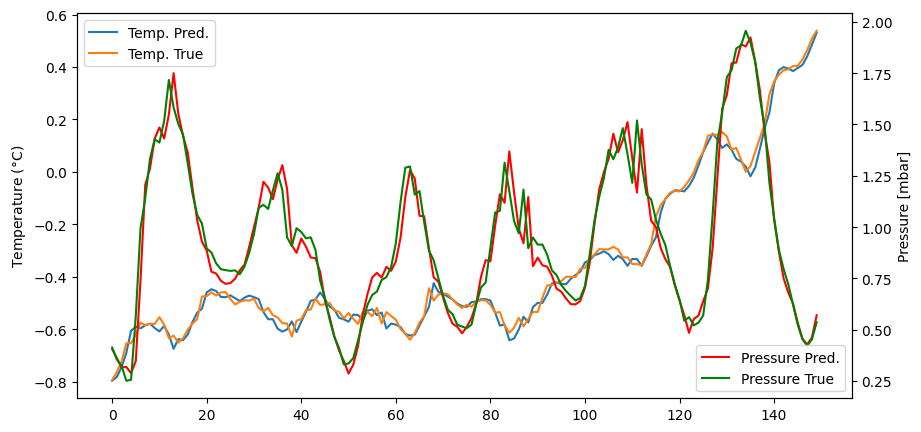

,Temperature Prediction,Temperature Actual,Pressure Prediction,Pressure Actual
0,-0.795724,-0.793439,0.404888,0.412451
1,-0.781187,-0.763123,0.361156,0.353683
2,-0.743381,-0.721893,0.314918,0.323123
3,-0.689530,-0.652773,0.317845,0.250251
4,-0.605077,-0.652773,0.287341,0.254952
...,...,...,...,...
145,0.396211,0.404641,0.533618,0.522935
146,0.408021,0.428894,0.455343,0.452413
147,0.440608,0.464060,0.428011,0.420678
148,0.485034,0.508927,0.461473,0.452413


In [169]:
plot_predictions_multi(model5, X_test, y_test)

Notice the absolute values are wrong currently since we performed the scaling to make our model work better. We need to invert the transform we did i.e.

$$\tilde{y}=\frac{y-\hat{y}}{\sigma_y}$$

was our transform (processing) our inverse (post-processing) will be,

$$y=\tilde{y}\sigma_y+\hat{y}$$

In [194]:
def postprocess(arr, mu, std):
    return (arr * std) + mu

y_test_post = y_test
y_test_post[:,0] = postprocess(y_test[:,0], mu1, std1)
y_test_post[:,1] = postprocess(y_test[:,1], mu2, std2)

start = 0
end = 150
preds = model5.predict(X_test)
p_pred, t_pred = preds[:,1], preds[:,0]
p_true, t_true = y_test_post[:,1], y_test_post[:,0]

p_pred = postprocess(p_pred, mu2, std2)
t_pred = postprocess(t_pred, mu1, std1)

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


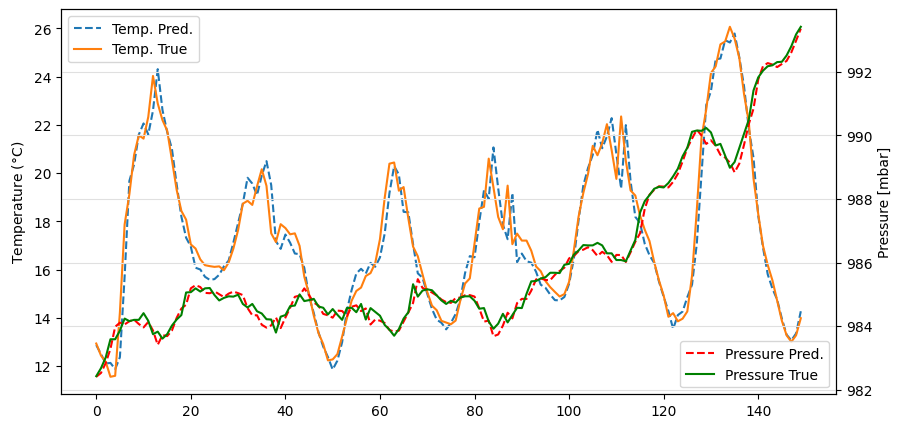

In [201]:
mpl.rcParams['grid.color'] = '#e0e0e0'

dft = pd.DataFrame({
    'Temperature Prediction': t_pred,
    'Temperature Actual': t_true,
    'Pressure Prediction': p_pred,
    'Pressure Actual': p_true,
})
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(dft['Temperature Prediction'][start:end], label='Temp. Pred.', linestyle="--")
ax.plot(dft['Temperature Actual'][start:end], label='Temp. True')
ax.set_ylabel(r"Temperature ($\degree$C)")
axs = ax.twinx()
axs.plot(dft['Pressure Prediction'][start:end], label="Pressure Pred.", color="red", linestyle="--")
axs.plot(dft['Pressure Actual'][start:end], label="Pressure True", color="green")
axs.set_ylabel("Pressure [mbar]")
ax.legend()
axs.legend(loc="lower right")
plt.grid()
plt.show()